In [1]:
import pandas as pd
import numpy as np
import lucem_illud_2020
import spacy
from nltk.tokenize import sent_tokenize
from lucem_illud_2020 import word_tokenize
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import sklearn.metrics.pairwise
import sklearn.decomposition
import matplotlib.pyplot as plt
from adjustText import adjust_text

In [2]:
file = '../../data/clean/speech.pkl'

In [3]:
df = pd.read_pickle(file)

In [4]:
df['tokenized_sentences'] = df['cleaned text'].apply(sent_tokenize)

In [5]:
df['tokenized_words_in_sentences'] = df['tokenized_sentences'].apply(lambda x: [word_tokenize(s) for s in x])

In [6]:
df['normalized_words_concat'] = df['normalized_words'].apply(lambda x: ' '.join(x))

In [7]:
df.head()

,filename,raw text,year,cleaned text,administration,president,year-president,tokenized_words,normalized_words,tokenized_sentences,tokenized_words_in_sentences,normalized_words_in_sentences,normalized_words_concat
0,mensaje-1956-mpu.txt,[MENSAJE DEL PRESIDENTE CONSTITUCIONAL DEL PER...,1956,MENSAJE DEL PRESIDENTE CONSTITUCIONAL DEL PERÚ...,Prado,Prado,1956-Prado,"[MENSAJE, DEL, PRESIDENTE, CONSTITUCIONAL, DEL...","[mensaje, presidente, constitucional, perú, do...",[MENSAJE DEL PRESIDENTE CONSTITUCIONAL DEL PER...,"[[MENSAJE, DEL, PRESIDENTE, CONSTITUCIONAL, DE...","[[mensaje, presidente, constitucional, perú, d...",mensaje presidente constitucional perú doctor ...
1,mensaje-1957-mpu.txt,[MENSAJE DEL PRESIDENTE CONSTITUCIONAL DEL PER...,1957,MENSAJE DEL PRESIDENTE CONSTITUCIONAL DEL PERÚ...,Prado,Prado,1957-Prado,"[MENSAJE, DEL, PRESIDENTE, CONSTITUCIONAL, DEL...","[mensaje, presidente, constitucional, perú, do...",[MENSAJE DEL PRESIDENTE CONSTITUCIONAL DEL PER...,"[[MENSAJE, DEL, PRESIDENTE, CONSTITUCIONAL, DE...","[[mensaje, presidente, constitucional, perú, d...",mensaje presidente constitucional perú doctor ...
2,mensaje-1958-mpu.txt,[MENSAJE DEL PRESIDENTE CONSTITUCIONAL DEL PER...,1958,MENSAJE DEL PRESIDENTE CONSTITUCIONAL DEL PERÚ...,Prado,Prado,1958-Prado,"[MENSAJE, DEL, PRESIDENTE, CONSTITUCIONAL, DEL...","[mensaje, presidente, constitucional, perú, do...",[MENSAJE DEL PRESIDENTE CONSTITUCIONAL DEL PER...,"[[MENSAJE, DEL, PRESIDENTE, CONSTITUCIONAL, DE...","[[mensaje, presidente, constitucional, perú, d...",mensaje presidente constitucional perú doctor ...
3,mensaje-1959-mpu.txt,[MENSAJE DEL PRESIDENTE CONSTITUCIONAL DEL PER...,1959,MENSAJE DEL PRESIDENTE CONSTITUCIONAL DEL PERÚ...,Prado,Prado,1959-Prado,"[MENSAJE, DEL, PRESIDENTE, CONSTITUCIONAL, DEL...","[mensaje, presidente, constitucional, perú, do...",[MENSAJE DEL PRESIDENTE CONSTITUCIONAL DEL PER...,"[[MENSAJE, DEL, PRESIDENTE, CONSTITUCIONAL, DE...","[[mensaje, presidente, constitucional, perú, d...",mensaje presidente constitucional perú doctor ...
4,mensaje-1960-mpu.txt,[MENSAJE DEL PRESIDENTE CONSTITUCIONAL DEL PER...,1960,MENSAJE DEL PRESIDENTE CONSTITUCIONAL DEL PERÚ...,Prado,Prado,1960-Prado,"[MENSAJE, DEL, PRESIDENTE, CONSTITUCIONAL, DEL...","[mensaje, presidente, constitucional, perú, do...",[MENSAJE DEL PRESIDENTE CONSTITUCIONAL DEL PER...,"[[MENSAJE, DEL, PRESIDENTE, CONSTITUCIONAL, DE...","[[mensaje, presidente, constitucional, perú, d...",mensaje presidente constitucional perú doctor ...


In [8]:
speeches = [TaggedDocument(doc, [year]) for doc, year in zip(list(df['normalized_words_concat']), list(df['year']))]

In [9]:
model = Doc2Vec(speeches, vector_size = 100)

In [10]:
targetDocs = df['year']

heatmapMatrixD = []

for tagOuter in targetDocs:
    column = []
    tagVec = model.docvecs[tagOuter].reshape(1, -1)
    for tagInner in targetDocs:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, model.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrixD.append(column)
heatmapMatrixD = np.array(heatmapMatrixD)

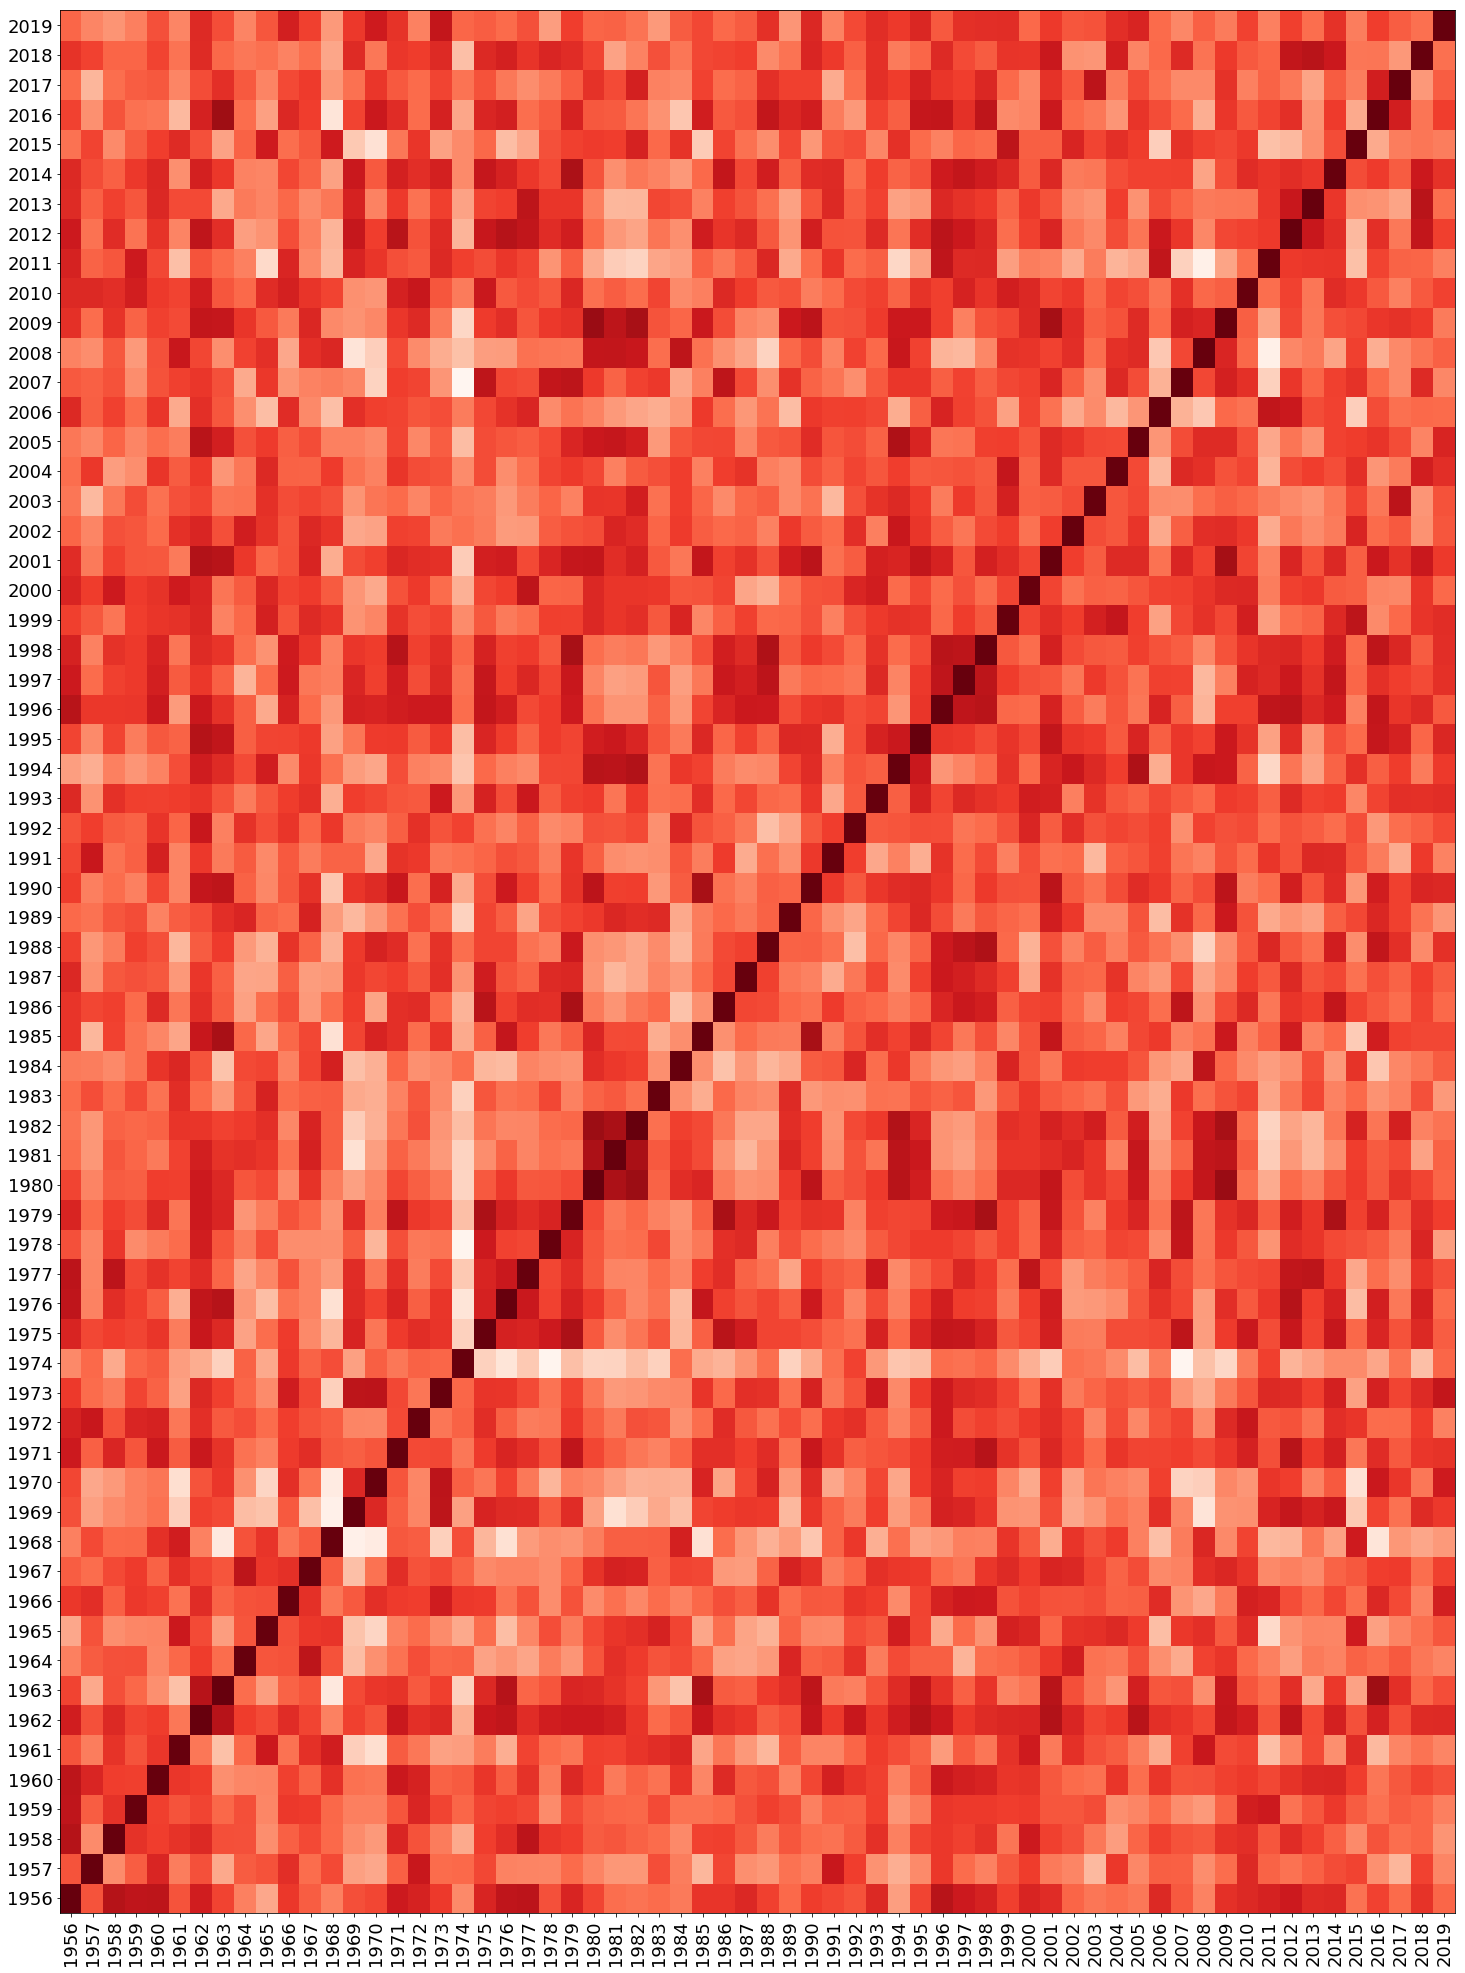

In [22]:
fig, ax = plt.subplots(figsize=(25,35))
hmap = ax.pcolor(heatmapMatrixD, cmap='Reds')
#cbar = plt.colorbar(hmap)

#cbar.set_label('cosine similarity', rotation=270)
ax.set_xticks(np.arange(heatmapMatrixD.shape[1]) + 0.5, minor=False)
ax.set_yticks(np.arange(heatmapMatrixD.shape[0]) + 0.5, minor=False)

ax.set_xticklabels(targetDocs, minor=False, rotation=90, size=18)
ax.set_yticklabels(targetDocs, minor=False, size=18)
#fig.tight_layout()

plt.savefig('../../outputs/word_embeddings/doc2vec_cosine_similarity_matrix.png')

In [24]:
model_result = np.zeros((len(df), 100))

In [25]:
years = list(df['year'])
for i, year in enumerate(years):
    model_result[i] = model[year]

In [26]:
pca = sklearn.decomposition.PCA(n_components = 2).fit(model_result)
reduced_pca = pca.transform(model_result)

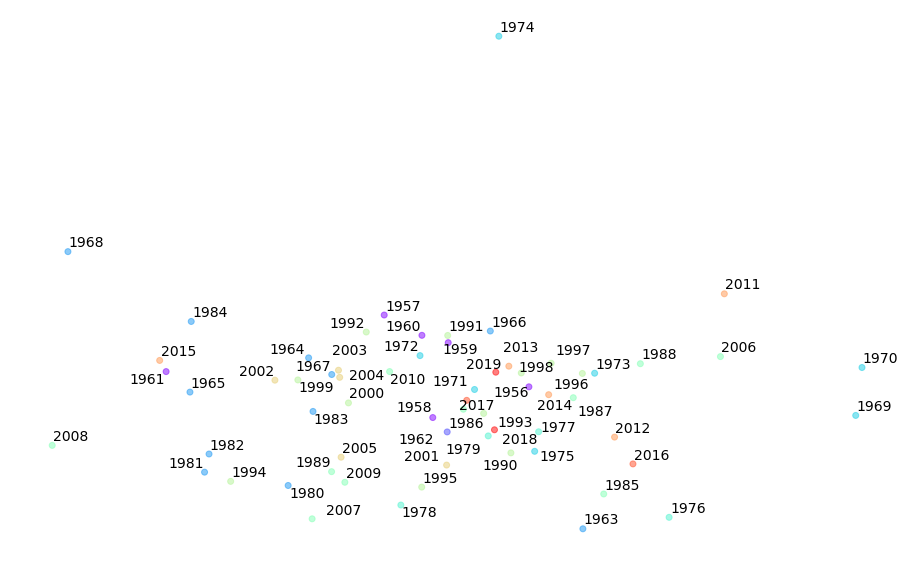

In [27]:
# Plotting

presidents = list(df['president'].unique())
colors = list(plt.cm.rainbow(np.linspace(0,1, len(presidents))))
colors_p = [colors[presidents.index(l)] for l in df['president']]

plt.figure(figsize=(16,10))
fig = plt.figure(1)
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(reduced_pca[:, 0], reduced_pca[:, 1], color = colors_p, alpha = 0.5)
plt.xticks(())
plt.yticks(())
texts = [plt.text(reduced_pca[:, 0][i],
                  reduced_pca[:, 1][i],
                  df['year'][i],
                  ha='center',
                  va='center',
                  size=14) for i in range(len(reduced_pca))]
adjust_text(texts)
plt.savefig('../../outputs/word_embeddings/doc2vec_pca_scatterplot_years.png')

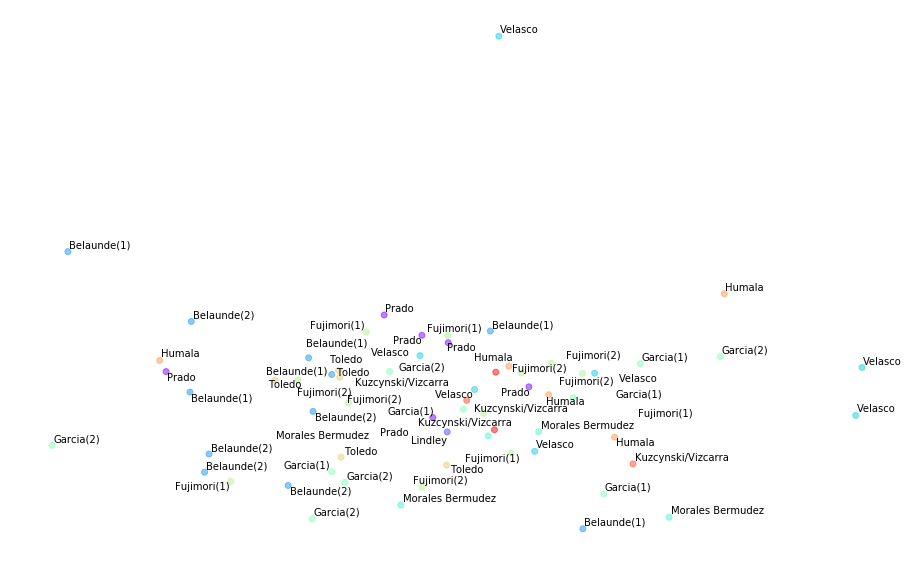

In [28]:
# Plotting
plt.figure(figsize=(16,10))
fig = plt.figure(1)
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(reduced_pca[:, 0], reduced_pca[:, 1], color = colors_p, alpha = 0.5)
plt.xticks(())
plt.yticks(())
texts = [plt.text(reduced_pca[:, 0][i],
                  reduced_pca[:, 1][i],
                  df['administration'][i],
                  ha='center',
                  va='center') for i in range(len(reduced_pca))]
adjust_text(texts)
plt.savefig('../../outputs/word_embeddings/doc2vec_pca_scatterplot_adm.png')